<a href="https://colab.research.google.com/github/TrippleA001/Air-Quality-Index-for-Urban-vs-Rural-Nigeria/blob/main/Individual/Lagos_PM10_pollutants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
df= pd.ExcelFile("/content/drive/MyDrive/PM 2.5 and PM 10 Prediction for PhD Physics/Reworked Lagos Hourly.xlsx")
data = pd.read_excel(df, 'Lagos hourly conformed')

Mounted at /content/drive/


In [3]:
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
0,2021-05-01,0,27,89,1011,0.705,4.38,5.94,6.24
1,2021-05-01,1,27,89,1010,1.259,4.61,6.27,6.55
2,2021-05-01,2,27,89,1010,0.705,5.18,7.08,7.45
3,2021-05-01,3,27,89,1009,0.917,4.98,6.89,7.33
4,2021-05-01,4,27,84,1009,0.777,5.06,7.08,7.5
...,...,...,...,...,...,...,...,...,...
17466,2023-04-30,19,29.4875,80,1011.015,1.059,10.0835,12.875,14.0415
17467,2023-04-30,20,29.208,82.375,1011.8,1.0555,14.708,20.2915,22.708
17468,2023-04-30,21,28.846,84.5,1012.405,1.051,17.6665,24.875,27.7915
17469,2023-04-30,22,28.5585,86.75,1012.79,1.051,18.9585,26.292,28.667


In [4]:
# summary statistics for the data used in buiding the ML algorithms
data.describe()

,Date,Time
count,17471,17471.000000
mean,2022-04-30 12:24:16.402038016,11.499342
min,2021-05-01 00:00:00,0.000000
25%,2021-10-29 12:00:00,5.500000
50%,2022-04-30 00:00:00,11.000000
75%,2022-10-30 00:00:00,17.000000
max,2023-04-30 00:00:00,23.000000
std,NaN,6.922036


In [5]:
# Checking for duplicate values in the data
data.duplicated().sum()

np.int64(2)

In [6]:
data[data.duplicated(keep=False)].head(70)

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
15672,2023-02-15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15688,2023-02-16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15695,2023-02-15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15711,2023-02-16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.isnull().sum()

,0
Date,0
Time,0
Temp(deg),604
Hum(%),593
Pre(hPa),593
WS (m/s),597
PM1(µg/m^3),589
PM2.5(µg/m^3),589
PM10(µg/m^3),589


In [8]:
data[data.isnull().any(axis=1)]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
66,2021-05-03,18,NaN,89,1109,2.198,0.12,0.39,0.48
71,2021-05-03,23,NaN,92,1011,2.159,1.7,2.6,2.9
106,2021-05-05,10,NaN,86,1012,1.589,1.76,2.56,2.77
2554,2021-08-15,10,NaN,81,1015,2.512,8.57,11.31,12.81
2582,2021-08-16,14,NaN,81,1016,3.052,7.72,9.06,9.47
...,...,...,...,...,...,...,...,...,...
15833,2023-02-21,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15834,2023-02-21,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15835,2023-02-21,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15836,2023-02-21,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.head(50)

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
0,2021-05-01,0,27,89,1011,0.705,4.38,5.94,6.24
1,2021-05-01,1,27,89,1010,1.259,4.61,6.27,6.55
2,2021-05-01,2,27,89,1010,0.705,5.18,7.08,7.45
3,2021-05-01,3,27,89,1009,0.917,4.98,6.89,7.33
4,2021-05-01,4,27,84,1009,0.777,5.06,7.08,7.5
5,2021-05-01,5,26,89,1009,1.507,5.84,8.04,8.47
6,2021-05-01,6,26,89,1009,1.157,7.1,9.94,10.41
7,2021-05-01,7,26,74,1010,1.377,7.73,10.64,11.11
8,2021-05-01,8,28,74,1010,1.237,7.07,9.81,10.27
9,2021-05-01,9,28,75,1010,1.187,5.25,7.39,7.77


In [10]:
data[data[["Temp(deg)","Hum(%)","Pre(hPa)","WS (m/s)","PM1(µg/m^3)","PM2.5(µg/m^3)","PM10(µg/m^3)"]].isnull().all(axis=1)]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
5518,2021-12-16,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5630,2021-12-21,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5632,2021-12-21,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5938,2022-01-04,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5939,2022-01-04,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15833,2023-02-21,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15834,2023-02-21,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15835,2023-02-21,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15836,2023-02-21,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.dropna(inplace=True)

In [12]:
data.describe()

,Date,Time
count,16863,16863.000000
mean,2022-04-21 15:49:09.297277952,11.499081
min,2021-05-01 00:00:00,0.000000
25%,2021-10-24 00:00:00,5.000000
50%,2022-04-19 00:00:00,12.000000
75%,2022-10-14 12:00:00,17.000000
max,2023-04-30 00:00:00,23.000000
std,NaN,6.922482


In [13]:

# 1. Identify object columns
object_cols = data.select_dtypes(include=['object']).columns

# 2. Convert to numeric, handling errors
for col in object_cols:
    try:
        data[col] = pd.to_numeric(data[col], errors='coerce') # 'coerce' replaces non-numeric values with NaN
    except ValueError:
        print(f"Column '{col}' could not be converted to numeric.")


<Axes: ylabel='PM10(µg/m^3)'>

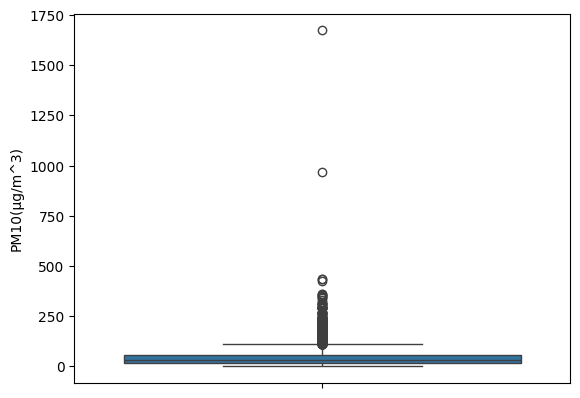

In [14]:
# Checking for outliers
sns.boxplot(data['PM10(µg/m^3)'])

In [15]:
#Outlier Detection using IQR
# Calculate the upper and lower limits
Q1 = data['PM10(µg/m^3)'].quantile(0.25)
Q3 = data['PM10(µg/m^3)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q3 - 3*IQR
upper = Q3 + 3*IQR

# Create arrays of Boolean values indicating the outlier rows
data = data[(data['PM10(µg/m^3)'] < upper) & (data['PM10(µg/m^3)'] > lower)]


In [16]:
data.describe()

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
count,16642,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000
mean,2022-04-22 06:20:33.024876800,11.533229,28.277442,79.535510,1012.750301,1.585541,22.360204,32.454385,38.151550
min,2021-05-01 00:00:00,0.000000,2.000000,-6.000000,1.510000,-0.561000,0.000000,0.080000,0.062000
25%,2021-10-22 00:00:00,6.000000,26.000000,71.661579,1010.235083,1.044375,11.458875,15.000000,16.708500
50%,2022-04-22 00:00:00,12.000000,27.835500,83.701400,1011.977466,1.380000,19.333000,27.083500,30.750000
75%,2022-10-15 00:00:00,17.750000,30.000000,89.713828,1013.195500,1.775375,28.750000,42.833500,53.417000
max,2023-04-30 00:00:00,23.000000,71.958500,1010.535000,11016.000000,19.042000,151.625000,156.750000,167.166500
std,NaN,6.908191,3.093744,15.702281,105.749109,0.875503,15.483679,23.911487,27.884474


In [17]:
data[(data['PM10(µg/m^3)'] < 1)]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
13,2021-05-01,13,34.0000,60.000,1010.00,2.137,0.3100,0.68,0.770
17,2021-05-01,17,33.0000,63.000,1008.00,3.752,0.0500,0.23,0.300
18,2021-05-01,18,32.0000,67.000,1008.00,2.090,0.0000,0.08,0.150
19,2021-05-01,19,30.0000,75.000,1008.00,3.752,0.0100,0.08,0.100
20,2021-05-01,20,30.0000,75.000,1009.00,3.198,0.0700,0.28,0.330
24,2021-05-02,0,29.0000,79.000,1011.00,2.644,0.2100,0.48,0.570
33,2021-05-02,9,30.0000,79.000,1011.00,1.536,0.5300,0.88,0.940
34,2021-05-02,10,31.0000,75.000,1010.00,2.644,0.1000,0.31,0.370
35,2021-05-02,11,32.0000,67.000,1010.00,1.536,0.0500,0.23,0.270
36,2021-05-02,12,33.0000,63.000,1010.00,2.090,0.0700,0.19,0.230


In [18]:
data[(data['PM10(µg/m^3)'] < 1)]["PM10(µg/m^3)"]=1

In [19]:
data["Date"].apply(lambda x: isinstance(x, datetime.datetime)).sum()

np.int64(16642)

In [20]:
data[~data["Date"].apply(lambda x: isinstance(x, datetime.datetime))]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)


In [21]:
data['Date'] = pd.to_datetime(data['Date'].astype(str), format='mixed')

In [22]:
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
0,2021-05-01,0,27.0000,89.000,1011.000,0.7050,4.3800,5.9400,6.2400
1,2021-05-01,1,27.0000,89.000,1010.000,1.2590,4.6100,6.2700,6.5500
2,2021-05-01,2,27.0000,89.000,1010.000,0.7050,5.1800,7.0800,7.4500
3,2021-05-01,3,27.0000,89.000,1009.000,0.9170,4.9800,6.8900,7.3300
4,2021-05-01,4,27.0000,84.000,1009.000,0.7770,5.0600,7.0800,7.5000
...,...,...,...,...,...,...,...,...,...
17466,2023-04-30,19,29.4875,80.000,1011.015,1.0590,10.0835,12.8750,14.0415
17467,2023-04-30,20,29.2080,82.375,1011.800,1.0555,14.7080,20.2915,22.7080
17468,2023-04-30,21,28.8460,84.500,1012.405,1.0510,17.6665,24.8750,27.7915
17469,2023-04-30,22,28.5585,86.750,1012.790,1.0510,18.9585,26.2920,28.6670


In [23]:
# Feature Engineering

data['Time'] = pd.to_datetime(data['Time'], format='%H').dt.time
data["DateTime"] = [datetime.datetime.combine(data["Date"].dt.date.iloc[i], data["Time"].iloc[i]) for i in range(len(data))]
data["Year"] =  data["DateTime"].dt.year
data["Month"] = data["DateTime"].dt.month
data["Day"] = data["DateTime"].dt.day
data["Hour"] = data["DateTime"].dt.hour

In [24]:
data.set_index("DateTime", inplace=True)
data.dropna(inplace=True)
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3),Year,Month,Day,Hour
DateTime,,,,,,,,,,,,,
2021-05-01 00:00:00,2021-05-01,00:00:00,27.0000,89.000,1011.000,0.7050,4.3800,5.9400,6.2400,2021,5,1,0
2021-05-01 01:00:00,2021-05-01,01:00:00,27.0000,89.000,1010.000,1.2590,4.6100,6.2700,6.5500,2021,5,1,1
2021-05-01 02:00:00,2021-05-01,02:00:00,27.0000,89.000,1010.000,0.7050,5.1800,7.0800,7.4500,2021,5,1,2
2021-05-01 03:00:00,2021-05-01,03:00:00,27.0000,89.000,1009.000,0.9170,4.9800,6.8900,7.3300,2021,5,1,3
2021-05-01 04:00:00,2021-05-01,04:00:00,27.0000,84.000,1009.000,0.7770,5.0600,7.0800,7.5000,2021,5,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 19:00:00,2023-04-30,19:00:00,29.4875,80.000,1011.015,1.0590,10.0835,12.8750,14.0415,2023,4,30,19
2023-04-30 20:00:00,2023-04-30,20:00:00,29.2080,82.375,1011.800,1.0555,14.7080,20.2915,22.7080,2023,4,30,20
2023-04-30 21:00:00,2023-04-30,21:00:00,28.8460,84.500,1012.405,1.0510,17.6665,24.8750,27.7915,2023,4,30,21


In [25]:
data.describe()

,Date,Temp(deg),Hum(%),Pre(hPa),WS (m/s),PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3),Year,Month,Day,Hour
count,16642,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000
mean,2022-04-22 06:20:33.024876800,28.277442,79.535510,1012.750301,1.585541,22.360204,32.454385,38.151550,2021.793234,6.682069,15.756399,11.533229
min,2021-05-01 00:00:00,2.000000,-6.000000,1.510000,-0.561000,0.000000,0.080000,0.062000,2021.000000,1.000000,1.000000,0.000000
25%,2021-10-22 00:00:00,26.000000,71.661579,1010.235083,1.044375,11.458875,15.000000,16.708500,2021.000000,4.000000,8.000000,6.000000
50%,2022-04-22 00:00:00,27.835500,83.701400,1011.977466,1.380000,19.333000,27.083500,30.750000,2022.000000,7.000000,16.000000,12.000000
75%,2022-10-15 00:00:00,30.000000,89.713828,1013.195500,1.775375,28.750000,42.833500,53.417000,2022.000000,10.000000,23.000000,17.750000
max,2023-04-30 00:00:00,71.958500,1010.535000,11016.000000,19.042000,151.625000,156.750000,167.166500,2023.000000,12.000000,31.000000,23.000000
std,NaN,3.093744,15.702281,105.749109,0.875503,15.483679,23.911487,27.884474,0.668355,3.380759,8.767865,6.908191


<Figure size 2500x1000 with 0 Axes>

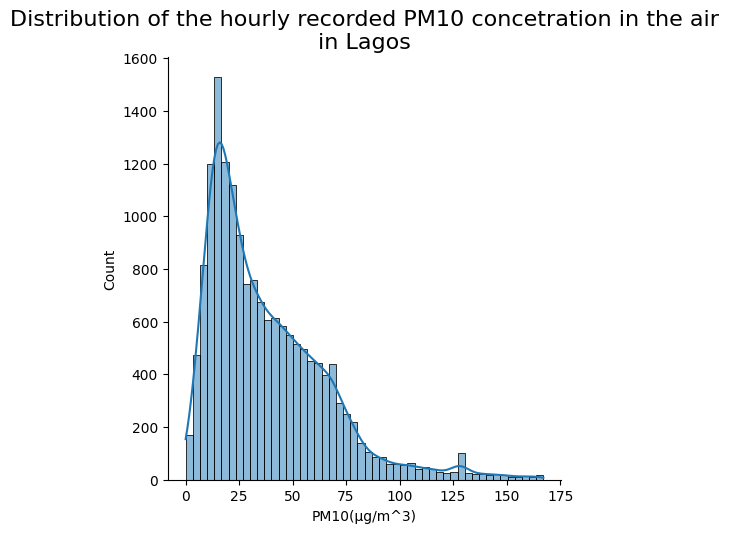

In [26]:
plt.figure(figsize=(25,10))
sns.displot(data['PM10(µg/m^3)'],bins=50, kde=True , lw=5)
plt.title('Distribution of the hourly recorded PM10 concetration in the air\nin Lagos',
          fontsize=16)
plt.show();

In [27]:
# find the daily average of PM10 contained in the air in any given hour
monthly_data = data[['PM10(µg/m^3)']]
monthly_data = monthly_data.resample('M').median()

In [28]:
monthly_data.interpolate(inplace=True)

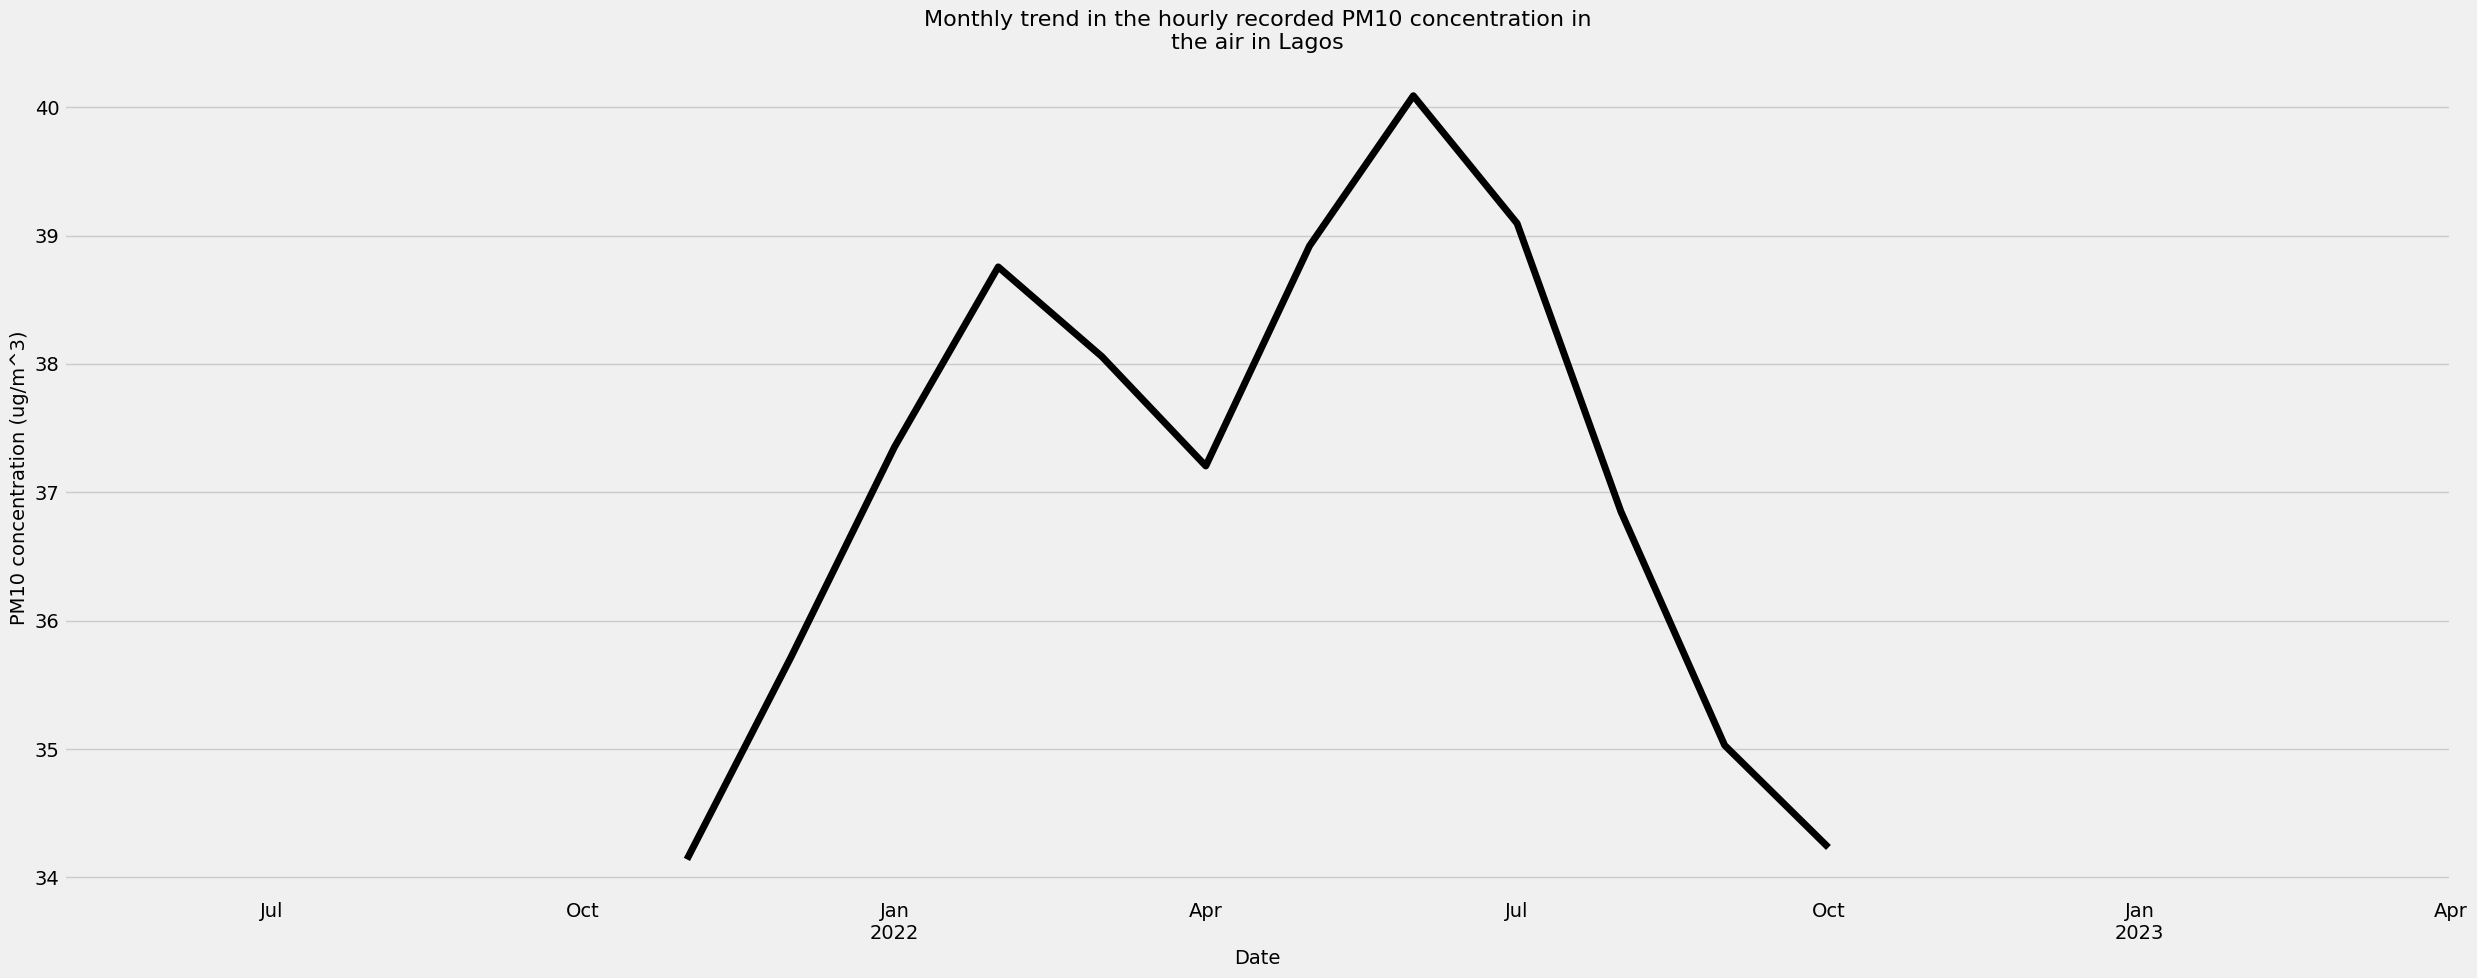

In [29]:
decomposition = seasonal_decompose(monthly_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(25,10),style='k-',linewidth=5,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly trend in the hourly recorded PM10 concentration in\nthe air in Lagos',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [30]:
daily_data = data[['PM10(µg/m^3)']].resample('D').median()

In [31]:
daily_data.interpolate(inplace=True)

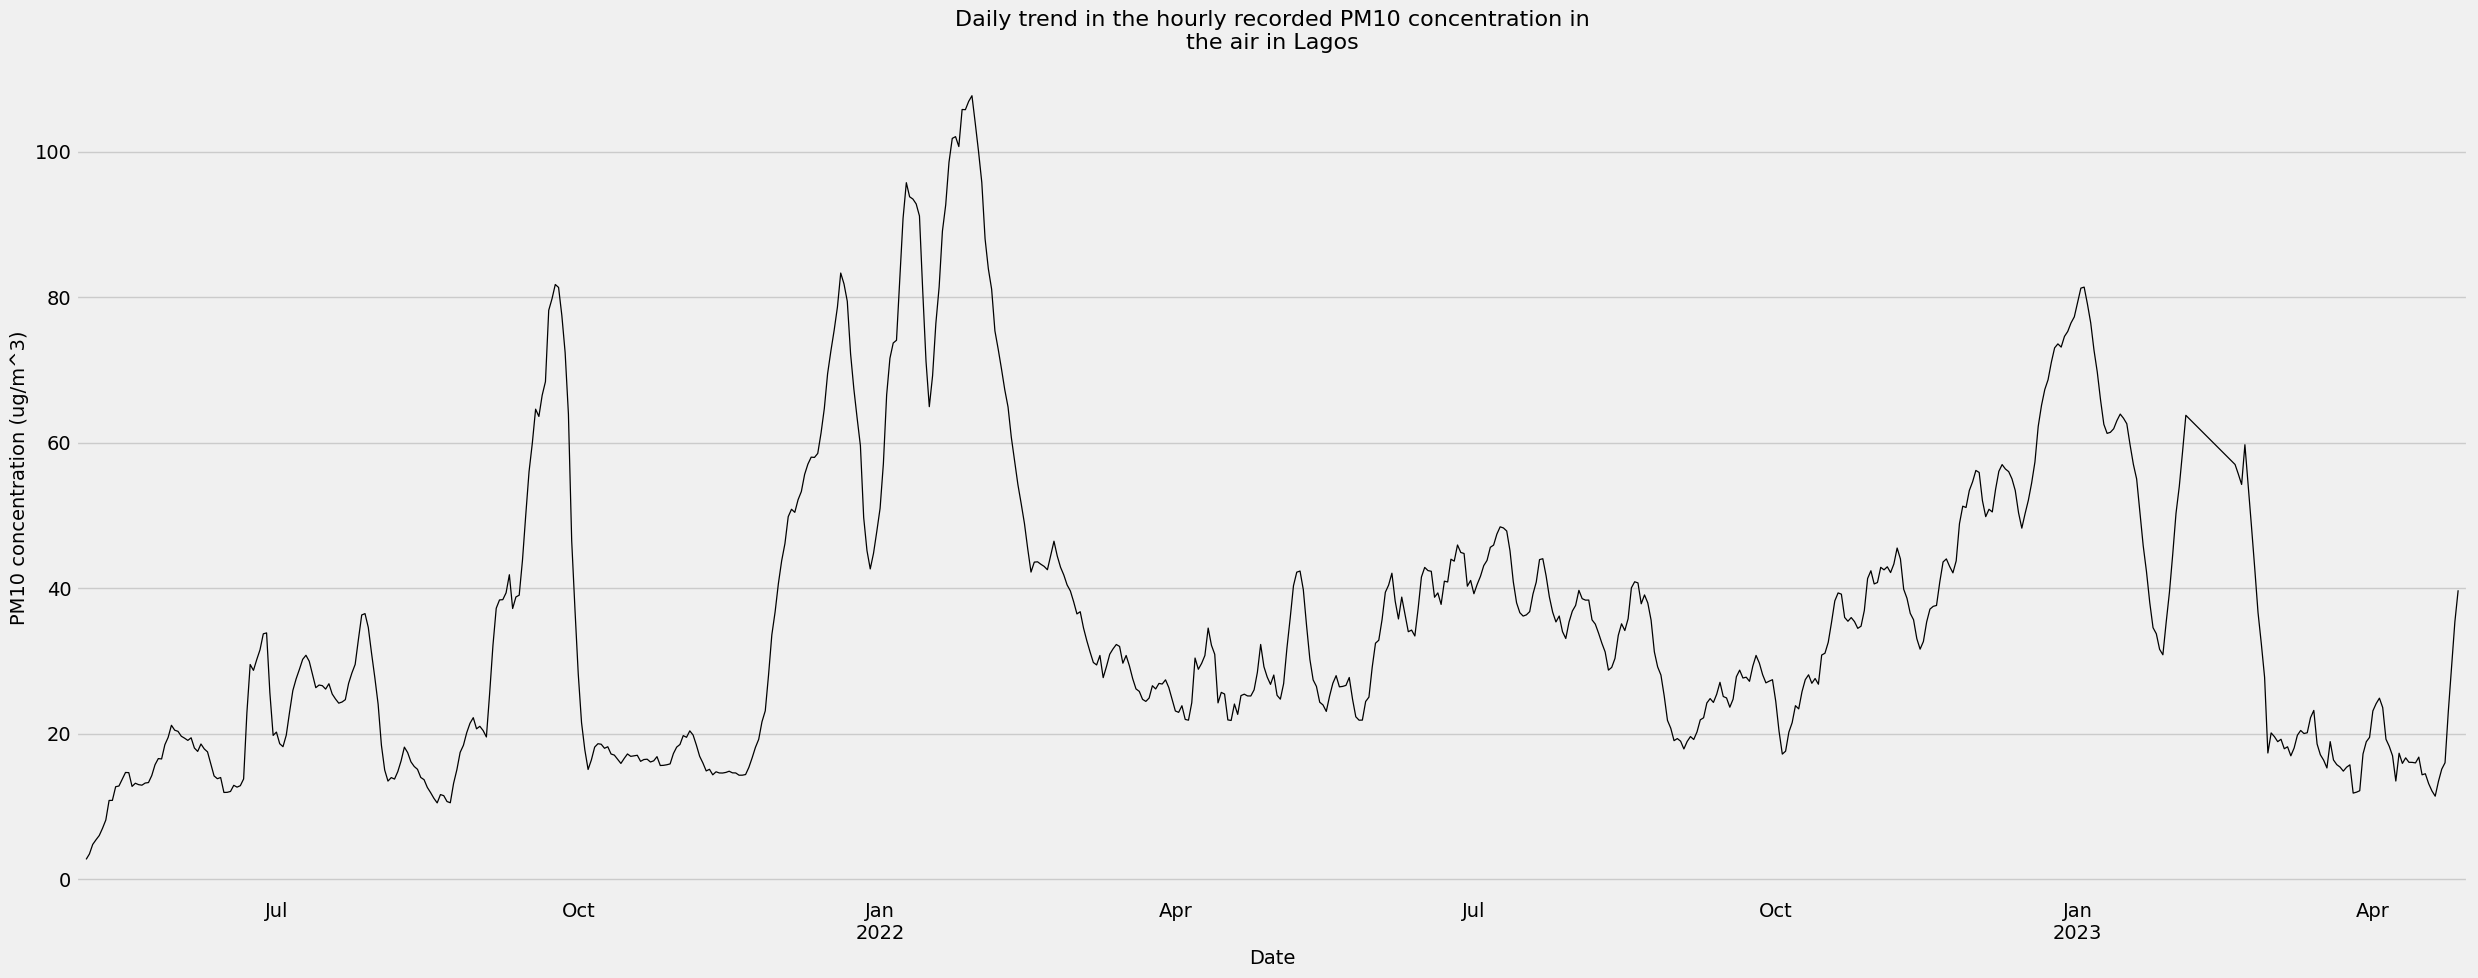

In [32]:
decomposition = seasonal_decompose(daily_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(25,10),style='k-',linewidth=.9,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Daily trend in the hourly recorded PM10 concentration in\nthe air in Lagos',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

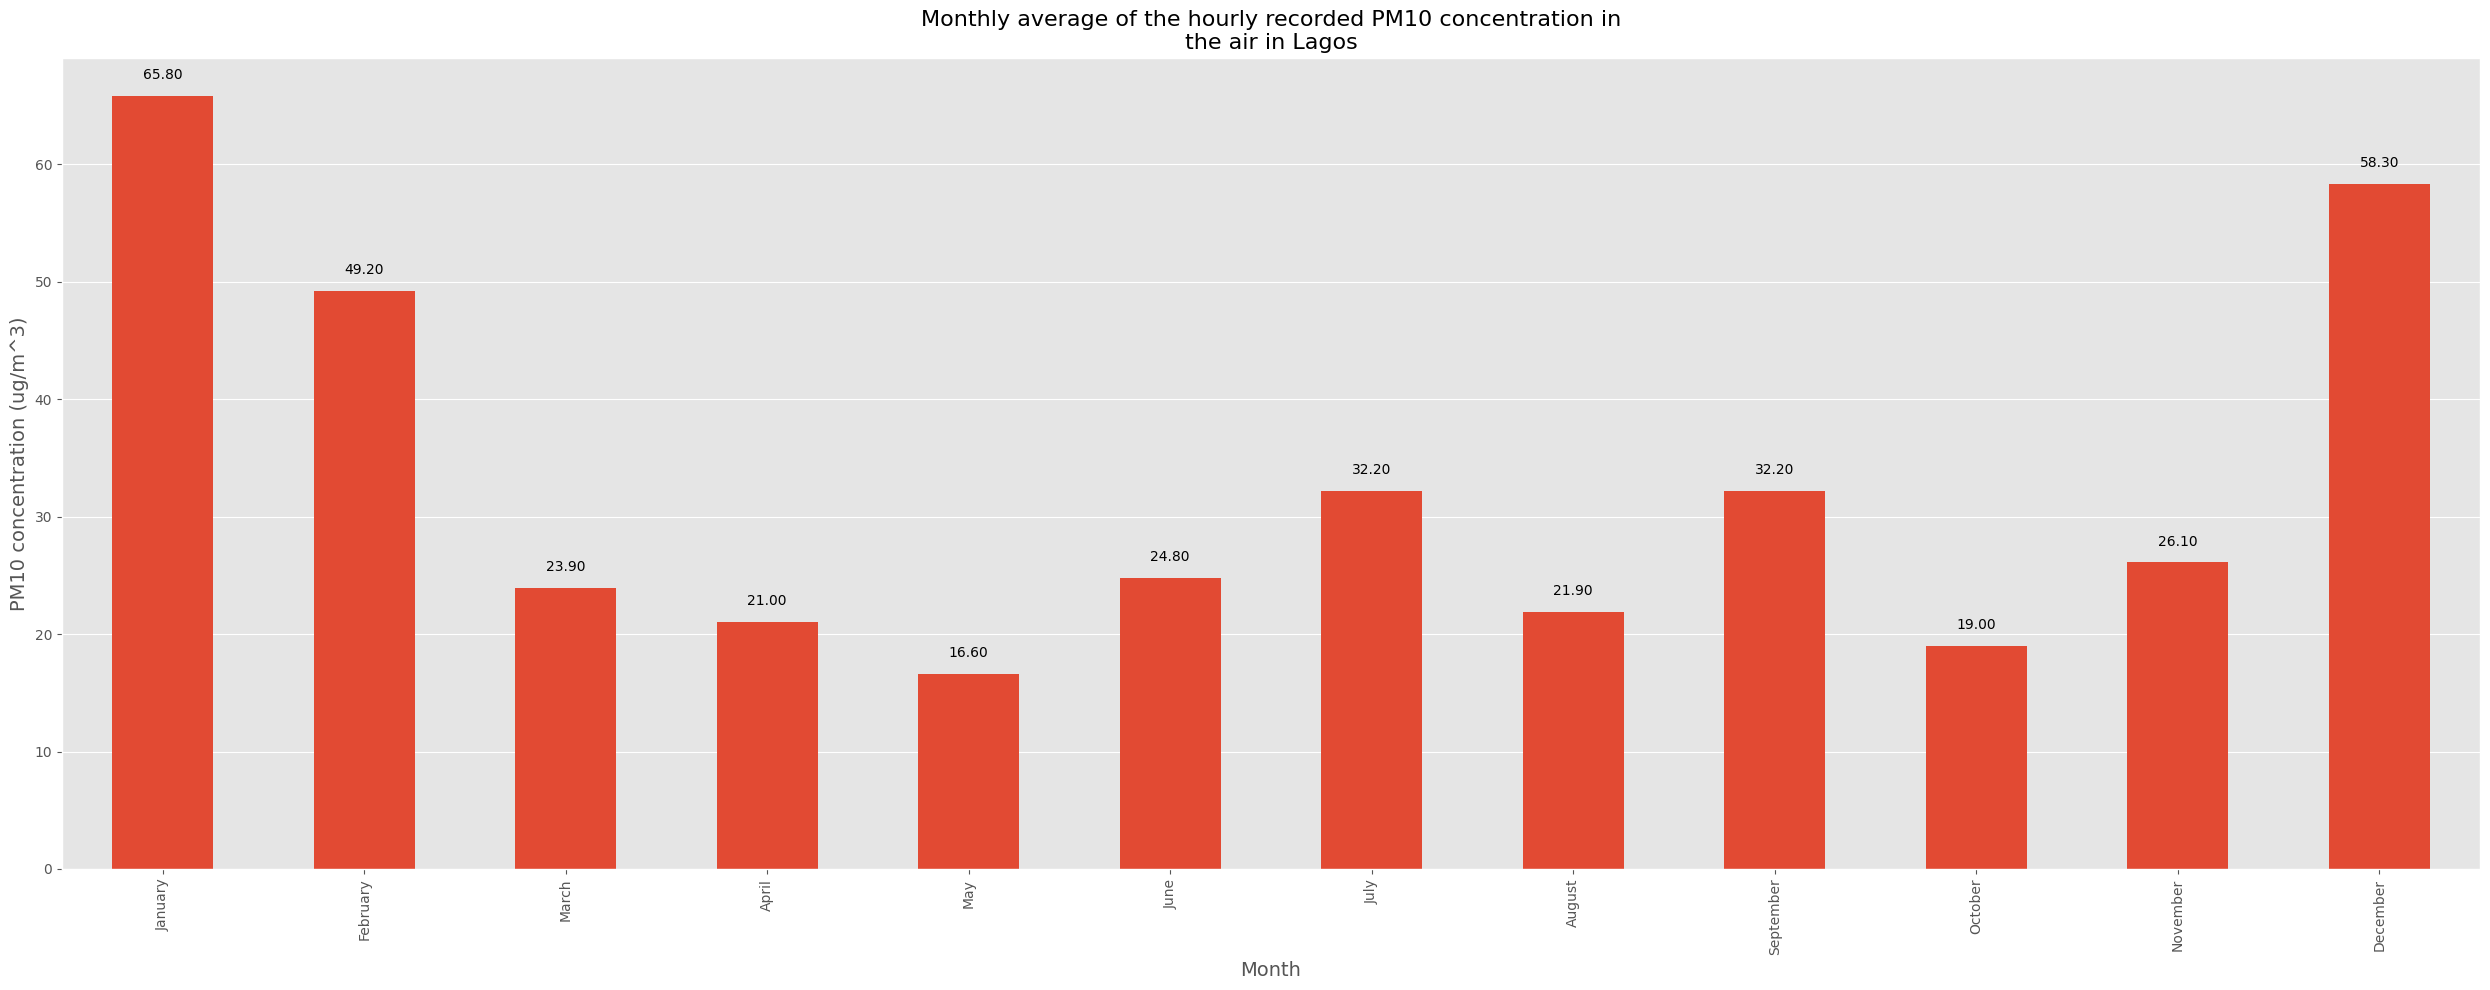

In [33]:
monthly_data = data[['Month','PM10(µg/m^3)']]
month = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(month,columns=['month'])
map_dict = {}
for i,j in enumerate(month):
    map_dict.setdefault(i+1,j)

monthly_data.Month = monthly_data.Month.map(map_dict)
monthly_average = monthly_data.groupby('Month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(25,10),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM10 concentration in\nthe air in Lagos',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

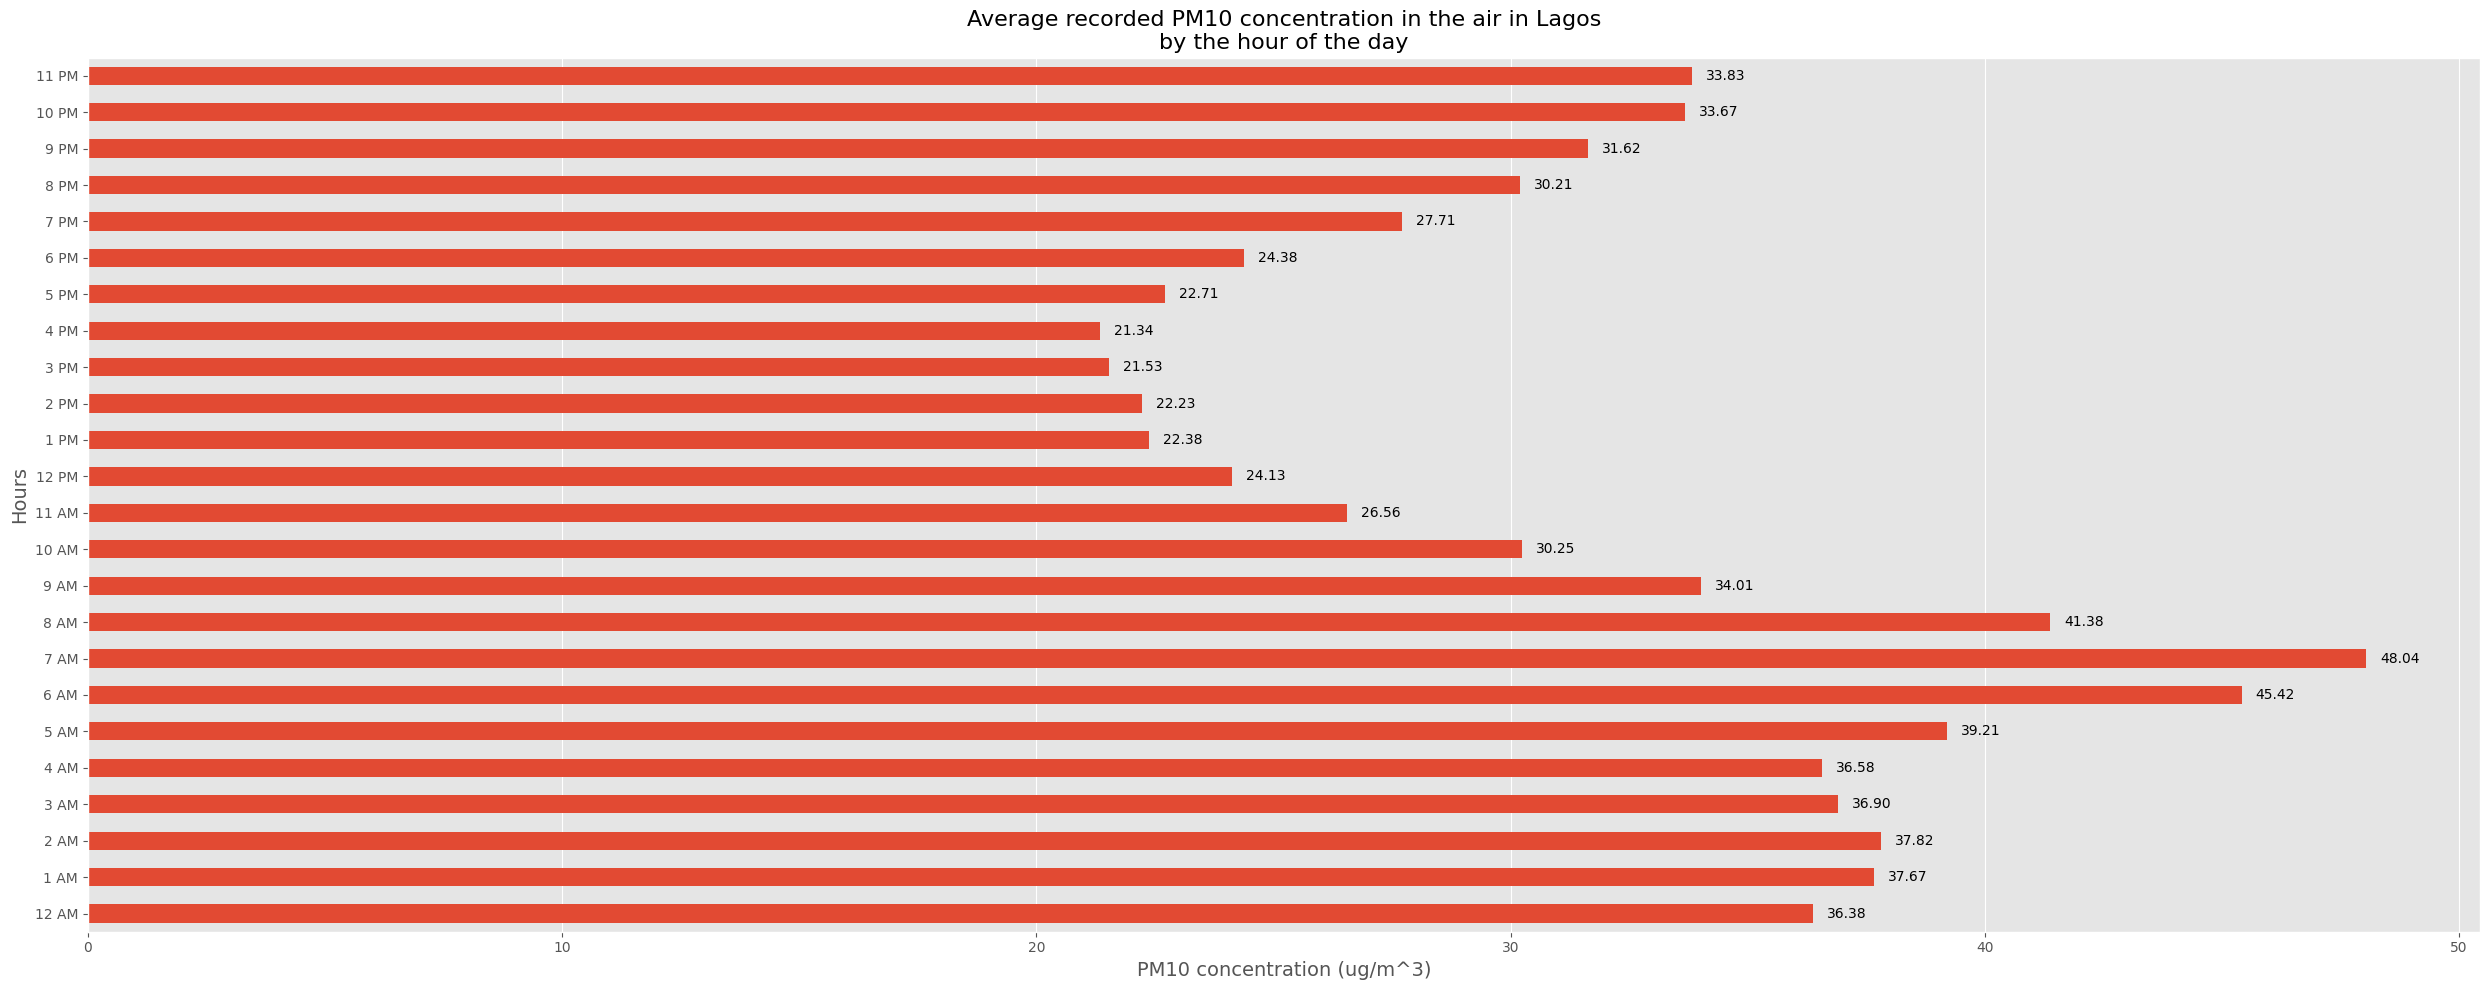

In [34]:
hourly_data = data[['Hour','PM10(µg/m^3)']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)

hourly_data = hourly_data.groupby('Hour').median().reset_index()
hourly_data.Hour = hourly_data.Hour.map(hour_dict)
hourly_data = hourly_data.set_index('Hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(25,10),legend=False,kind='barh',linewidth=.9)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM10 concentration in the air in Lagos\nby the hour of the day',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show();

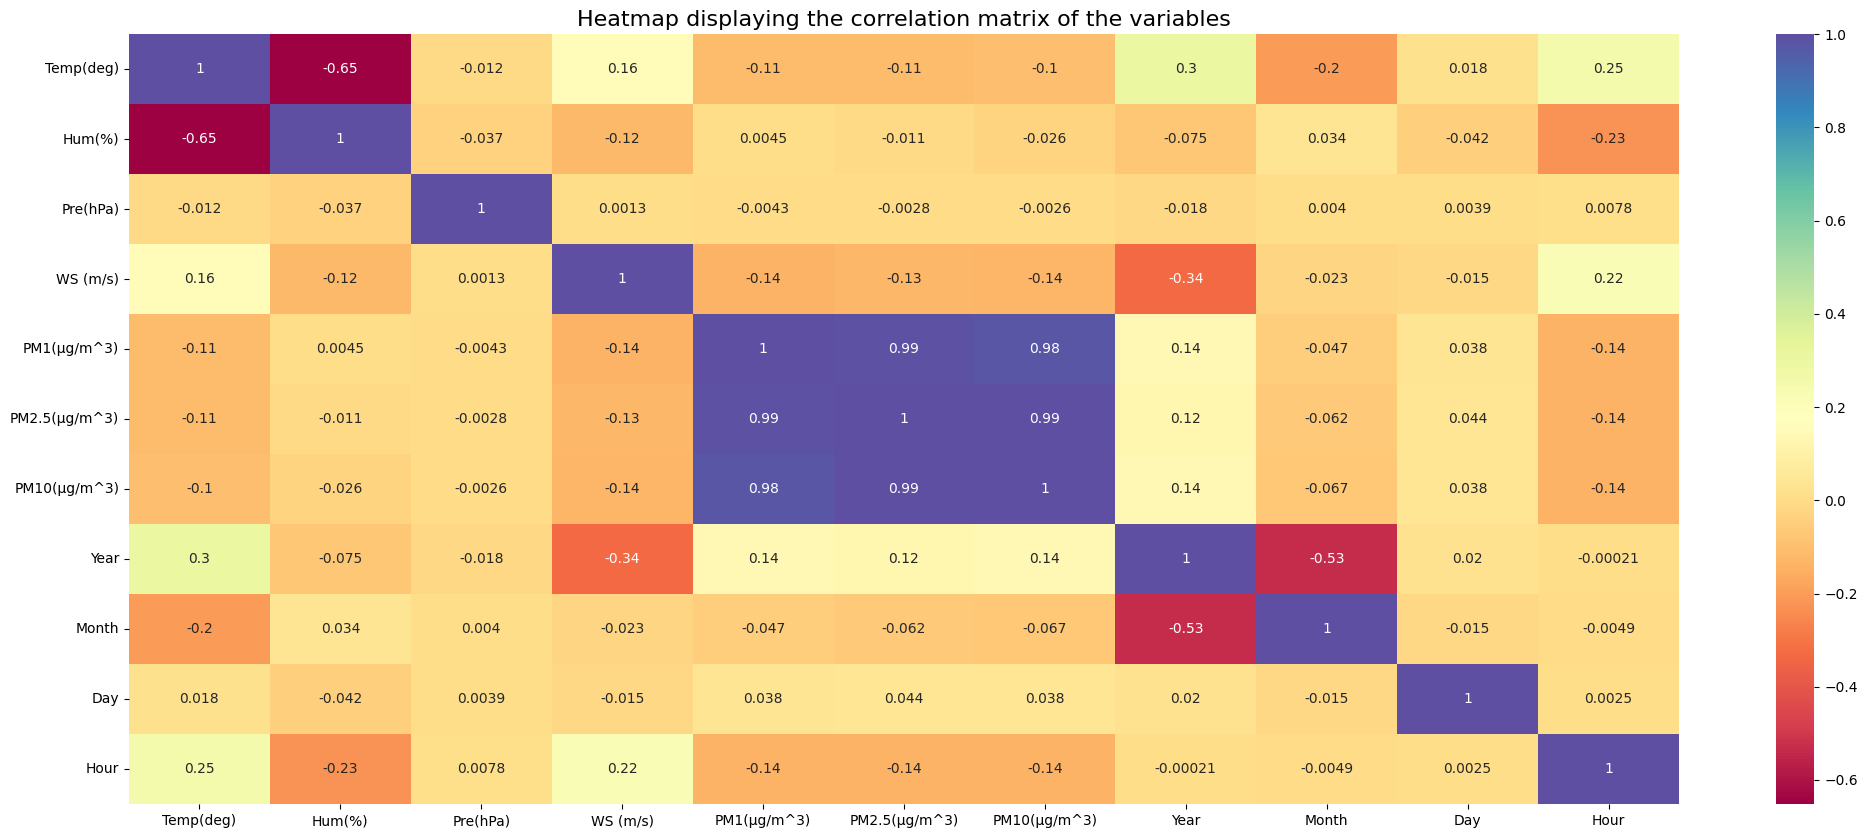

In [35]:
# Visualize the relationships between the features of the data
plt.figure(figsize=(25,10))
correlation_data = data[['Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)',
                        'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)',
                        'Year', 'Month', 'Day', 'Hour',]]
sns.heatmap(correlation_data.corr(),annot = True,cmap="Spectral",)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show;

Model Training and Evaluation

In [36]:
data.columns

Index(['Date', 'Time', 'Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)',
       'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)', 'Year', 'Month', 'Day',
       'Hour'],
      dtype='object')

In [37]:
cols_to_drop = ['Date', 'Time' , 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)']
X = data.drop(cols_to_drop,axis=1)
y= data['PM10(µg/m^3)']

In [38]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [39]:
# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Year,Month,Day,Hour
0,-0.412924,0.602764,-0.016552,-1.005784,-1.18688,-0.497557,-1.68306,-1.669551
1,-0.412924,0.602764,-0.026009,-0.372986,-1.18688,-0.497557,-1.68306,-1.524791
2,-0.412924,0.602764,-0.026009,-1.005784,-1.18688,-0.497557,-1.68306,-1.380031
3,-0.412924,0.602764,-0.035465,-0.763630,-1.18688,-0.497557,-1.68306,-1.235271
4,-0.412924,0.284330,-0.035465,-0.923543,-1.18688,-0.497557,-1.68306,-1.090511


In [40]:
# we now split out data into train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=53)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=53)

In [41]:
# instantiate the linear regression model
lin_model = LinearRegression()

# Fitting the model
lin_model.fit(X_train,y_train)

# Model Performance on the validation data
linear_reg_perf_test = model_performance_regression(lin_model, X_val, y_val)
linear_reg_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,26.67742,20.831786,0.103836,0.099507,125.512626


In [42]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 53)

# Fitting the model
rf_regression = rf_regressor.fit(X_train, y_train)

# Model Performance on the validation data
rf_regressor_perf_test = model_performance_regression(rf_regressor, X_val, y_val)
rf_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,13.328137,8.387656,0.776314,0.775233,37.378138


In [43]:
# Support Vector Machine Regression
random_state=53
svr = SVR(kernel ='linear').fit(X_train, y_train)

# Model Performance on the validation data
svr_regressor_perf_test = model_performance_regression(svr, X_val, y_val)
svr_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,27.394225,19.771768,0.055031,0.050466,96.625365


In [44]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features=None,
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(X_train,y_train)

# Model Performance on the validation data
grad_boost_perf_test = model_performance_regression(grad_boost, X_val, y_val)
grad_boost_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,14.175813,9.454196,0.746956,0.745734,43.910938


In [45]:
#Model performance comparison

models_test_comp_df = pd.concat(
    [
        linear_reg_perf_test.T,
        rf_regressor_perf_test.T,
        svr_regressor_perf_test.T,
        grad_boost_perf_test.T,
        ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Multiple Linear Regression",
    "Random Forest ",
    "Support Vector Machine",
    "Gradient Boosting",
    ]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Multiple Linear Regression,26.677420,20.831786,0.103836,0.099507,125.512626
Random Forest,13.328137,8.387656,0.776314,0.775233,37.378138
Support Vector Machine,27.394225,19.771768,0.055031,0.050466,96.625365
Gradient Boosting,14.175813,9.454196,0.746956,0.745734,43.910938


In [46]:
# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(models_test_comp_df, var_name='Model', value_name='Value', ignore_index = False)
df_melted.reset_index(inplace=True)
df_melted

,index,Model,Value
0,RMSE,Multiple Linear Regression,26.677420
1,MAE,Multiple Linear Regression,20.831786
2,R-squared,Multiple Linear Regression,0.103836
3,Adj. R-squared,Multiple Linear Regression,0.099507
4,MAPE,Multiple Linear Regression,125.512626
5,RMSE,Random Forest,13.328137
6,MAE,Random Forest,8.387656
7,R-squared,Random Forest,0.776314
8,Adj. R-squared,Random Forest,0.775233
9,MAPE,Random Forest,37.378138


In [47]:
def plot_model_comparison(df_melted):
  """
  Generates a bar chart for model comparison.

  Args:
    df_melted: A pandas DataFrame in melted format, containing the model performance metrics.

  Returns:
    None. Displays the bar chart.
  """

  # Create a list of subplots
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))

  # Loop through each index value and create a bar chart for each
  for i, index in enumerate(df_melted['index'].unique()):
      # Filter the data for the current index value
      data = df_melted[df_melted['index'] == index]

      # Create a bar chart
      axes[i].bar(data['Model'], data['Value'])
      axes[i].set_title(index)
      axes[i].tick_params(axis='x', labelrotation=90)
      axes[i].bar_label(axes[i].containers[0], fmt='%.2f', padding=12)

  plt.show()  # Display the chart

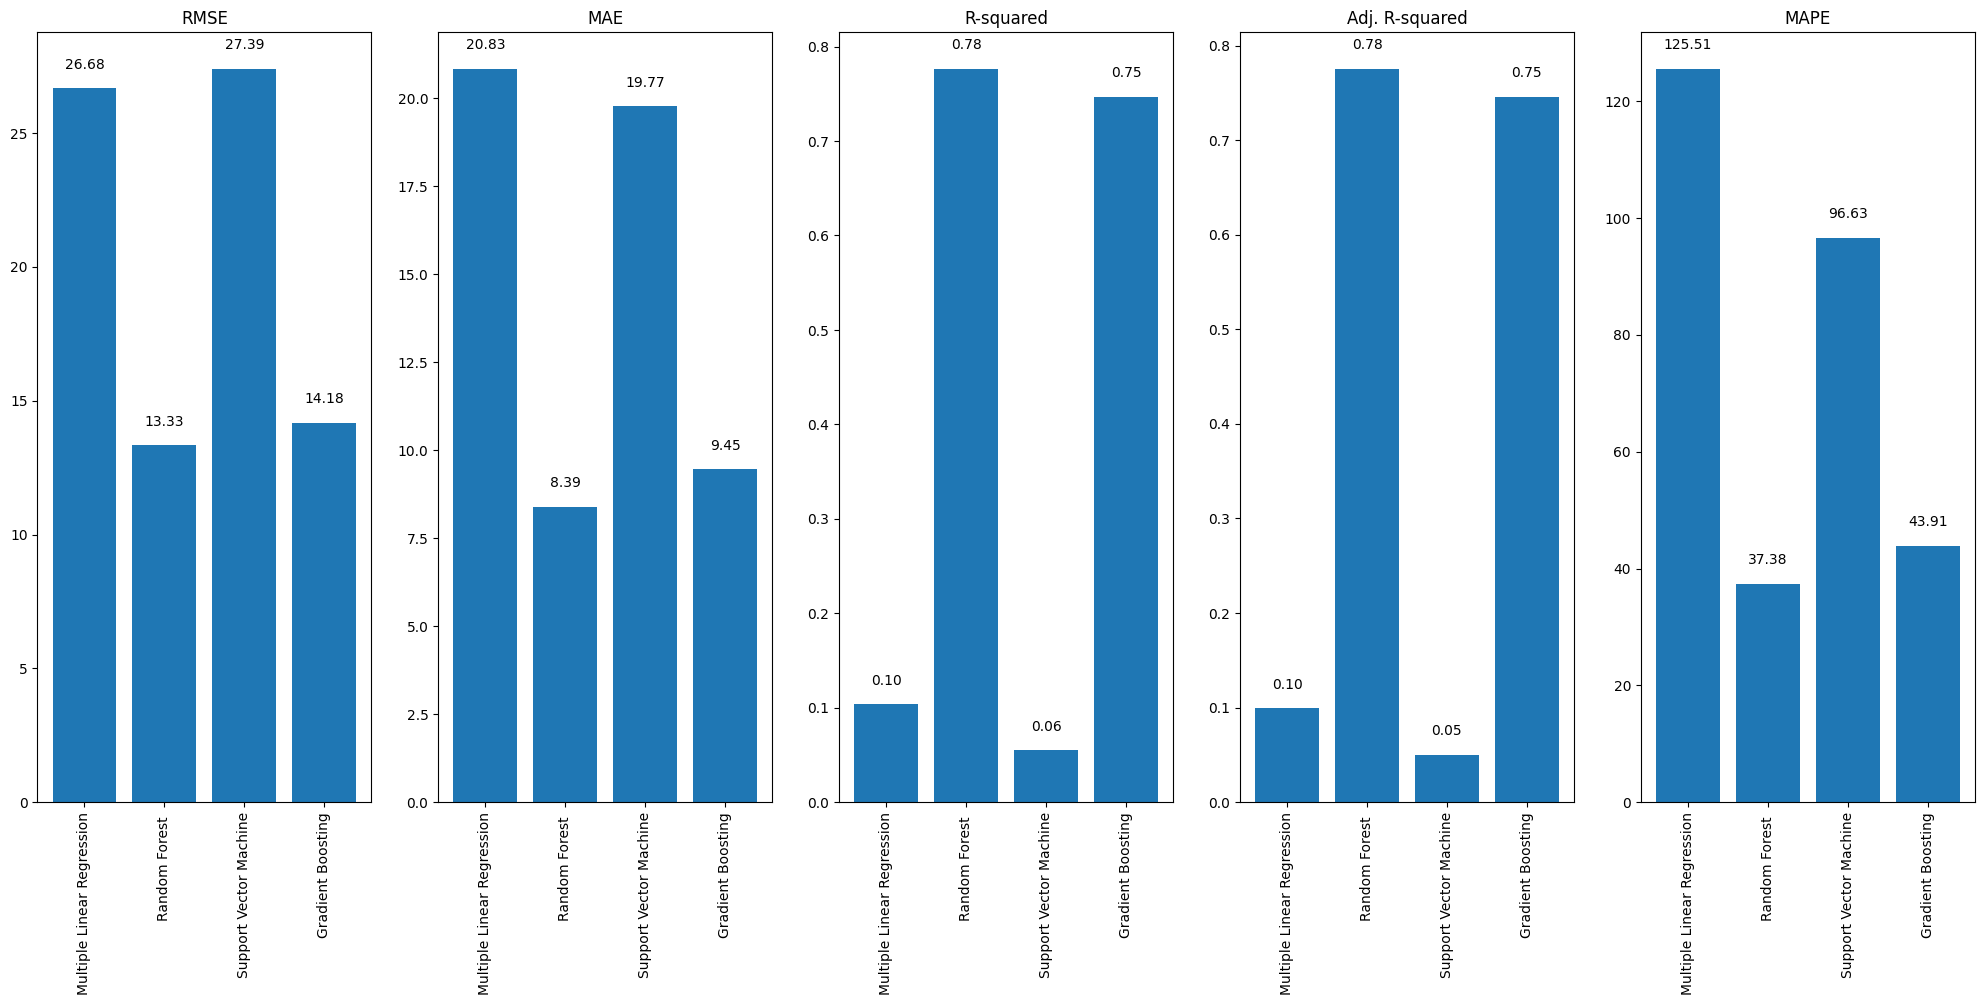

In [48]:
plot_model_comparison(df_melted)

In [49]:
#Hyperparameter tunning for Random Forest

# Define the hyperparameter search space
param_dist = {
    'n_estimators': np.arange(50, 501, 50),  # Expanded range
    'max_depth': [None, 5, 10, 20],  # Added values
    'min_samples_split': np.arange(2, 11, 2),  # Expanded range
    'min_samples_leaf': np.arange(1, 5, 1),  # Added values
    'max_features': [None, 'sqrt', 'log2'],  # Added options
    'bootstrap': [True, False],  # Added option
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Evaluation metric
    random_state=53,  # For reproducibility
    n_jobs=-1,  # Use all available cores for parallel processing
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

In [50]:
best_params = {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}
# Random Forest Regressor
best_model = RandomForestRegressor(**best_params)

# Fitting the model
best_model = best_model.fit(X_train, y_train)

# Evaluate the tuned random forest model on the validation data
RF_tuned_model =  model_performance_regression(best_model, X_val, y_val)
RF_tuned_model

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,13.063253,8.262488,0.785117,0.784079,36.043829


In [51]:
# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(models_test_comp_df, var_name='Model', value_name='Value', ignore_index = False)
df_melted.reset_index(inplace=True)
df_melted

,index,Model,Value
0,RMSE,Multiple Linear Regression,26.677420
1,MAE,Multiple Linear Regression,20.831786
2,R-squared,Multiple Linear Regression,0.103836
3,Adj. R-squared,Multiple Linear Regression,0.099507
4,MAPE,Multiple Linear Regression,125.512626
5,RMSE,Random Forest,13.328137
6,MAE,Random Forest,8.387656
7,R-squared,Random Forest,0.776314
8,Adj. R-squared,Random Forest,0.775233
9,MAPE,Random Forest,37.378138


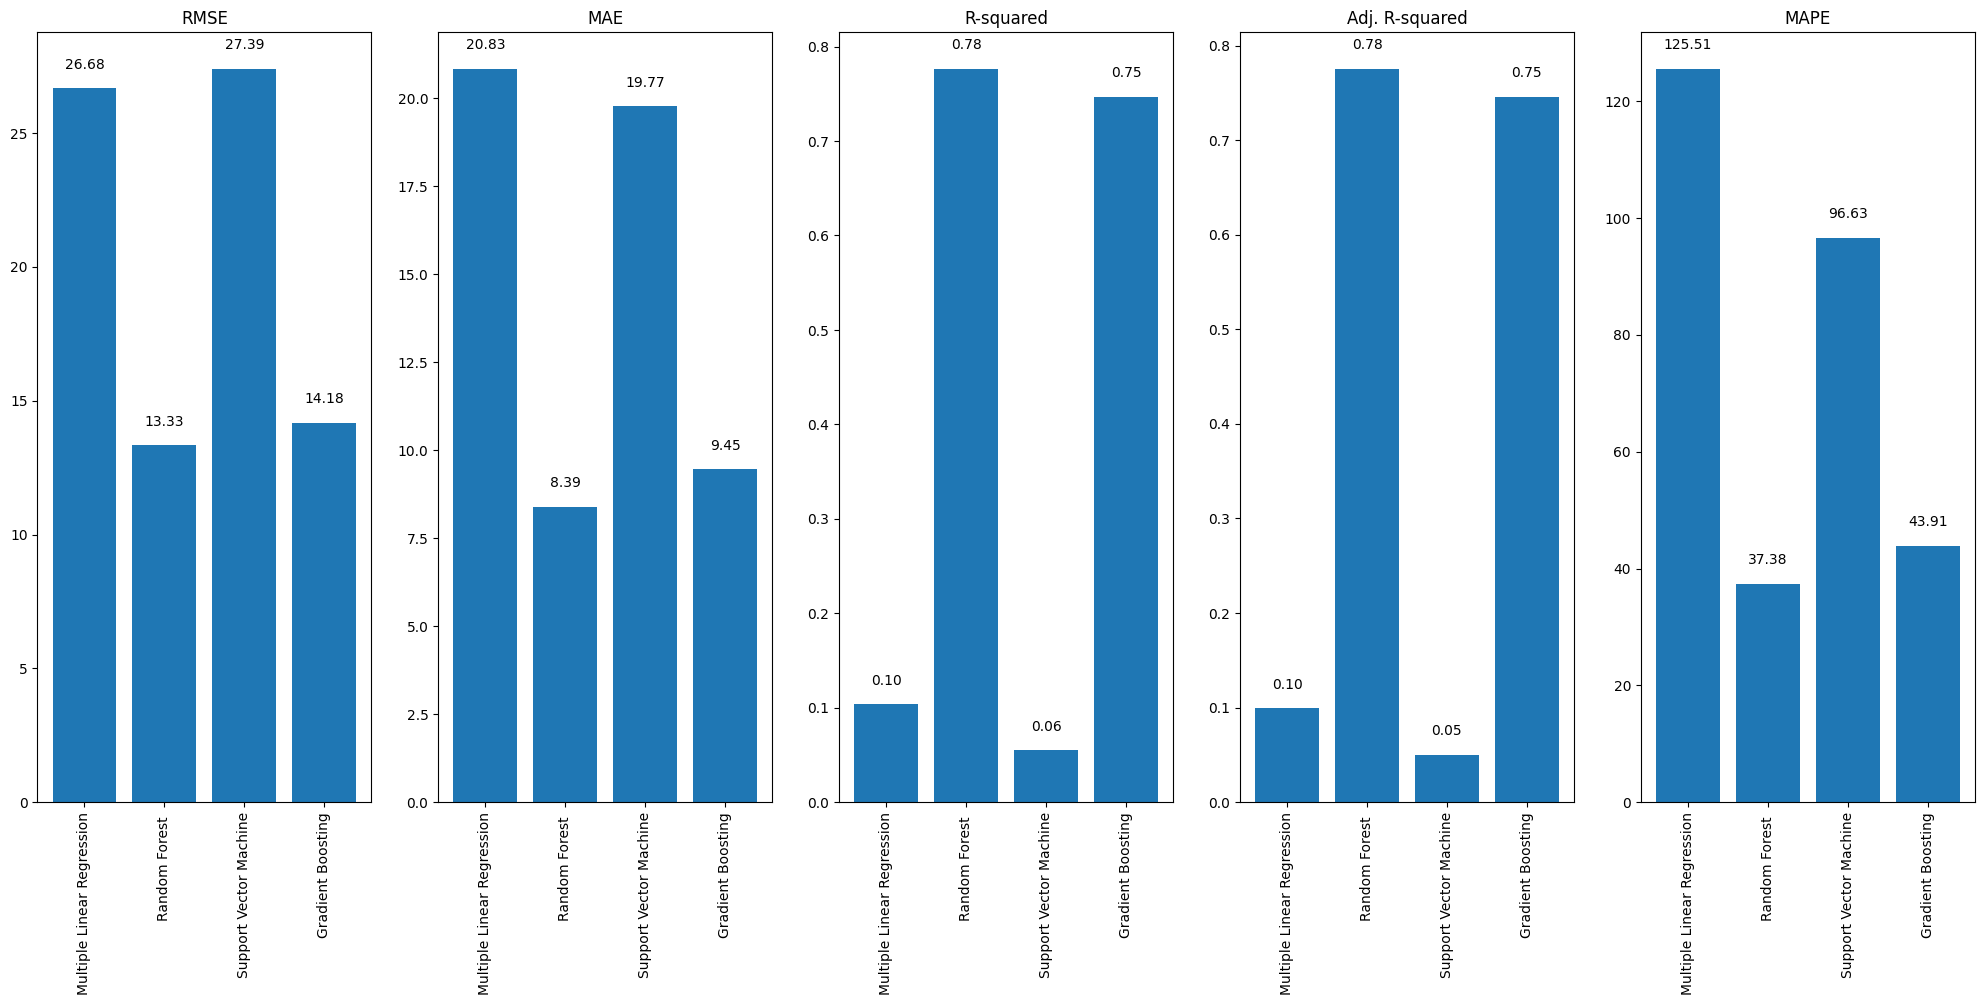

In [52]:
plot_model_comparison(df_melted)

In [53]:
# Evaluate the best model on the test data
RF_tuned_model =  model_performance_regression(best_model, X_test, y_test)
RF_tuned_model

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,13.898116,8.574046,0.755923,0.754743,35.25083


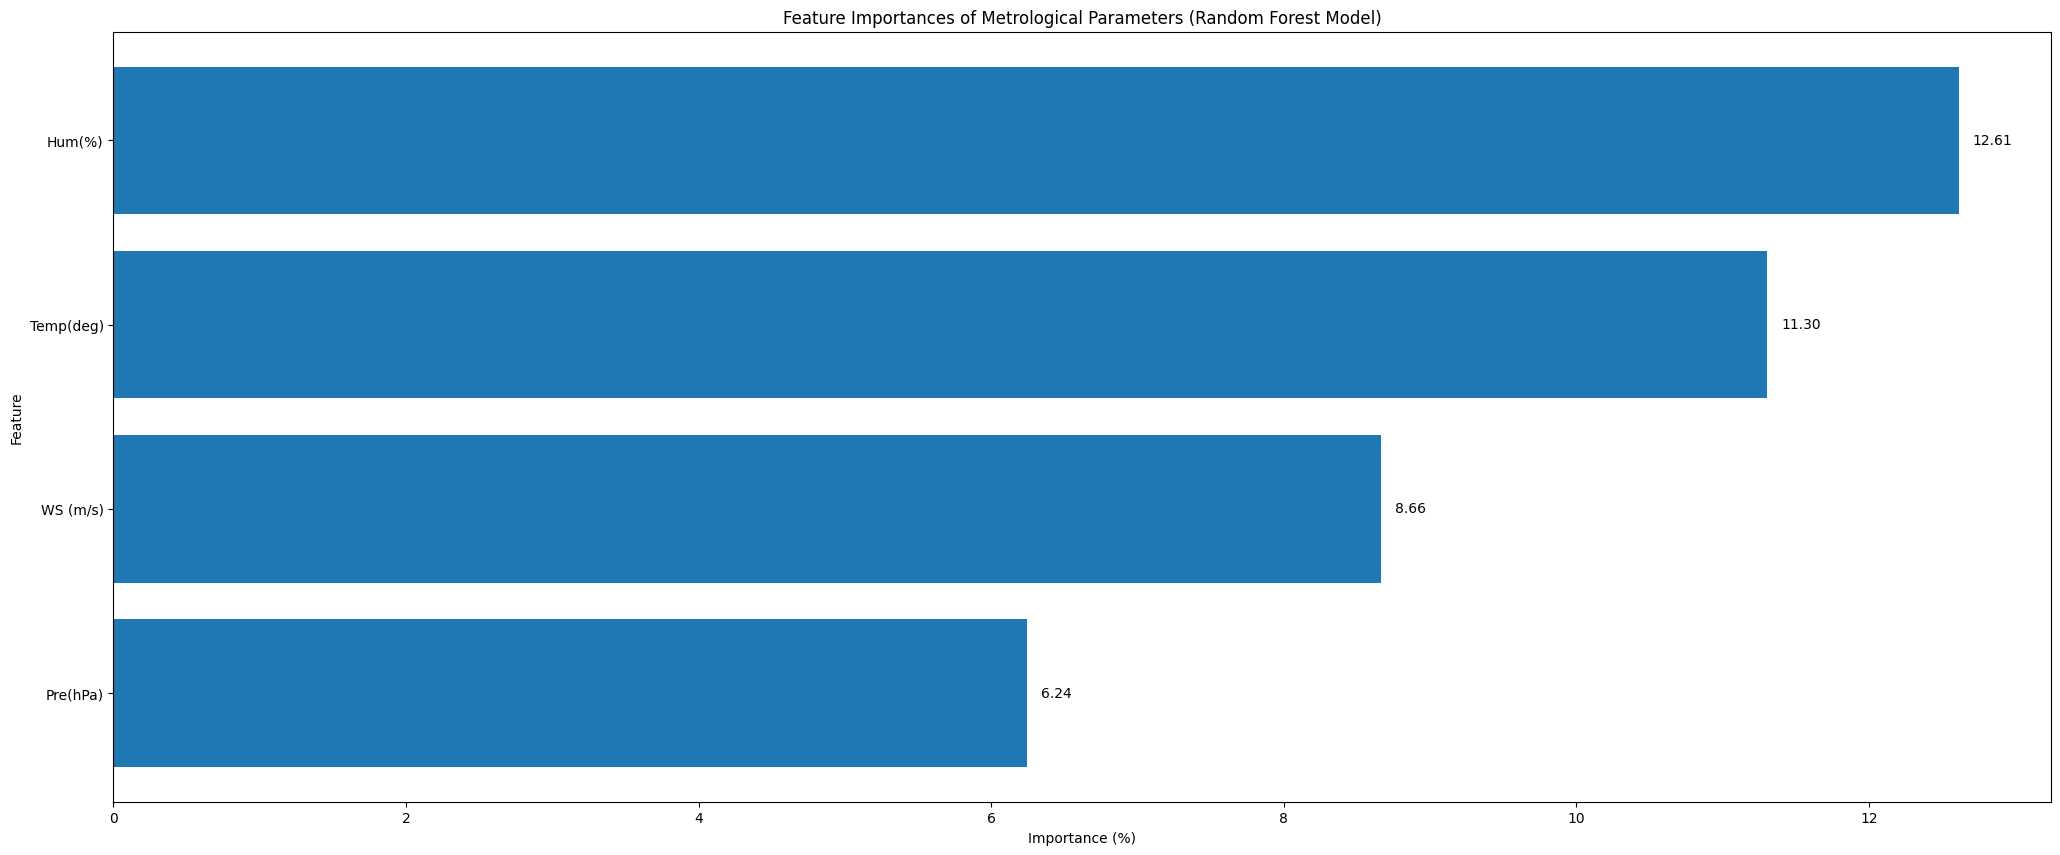

In [54]:
# Feature importance of the best model (Random Forest model)
# Get feature importances
importances = rf_regressor.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort importances and feature names
importances, feature_names = zip(*sorted(zip(importances*100, feature_names)))

#Keep only Metrological Features
features_to_keep = ['Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)','Wind direction']

importance =  [importance for importance, feature_name in zip(importances, feature_names) if feature_name in features_to_keep]
feature_names = [name for name in feature_names if name in features_to_keep]

# Create a vertical bar chart
plt.figure(figsize=(25, 10))
plt.barh(feature_names, importance)

# Show plot

# Get the current Axes object
ax = plt.gca()
# Add value labels on top of bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=10)

# Set title and axis labels
plt.title("Feature Importances of Metrological Parameters (Random Forest Model)")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")

# Show the plot
plt.show();

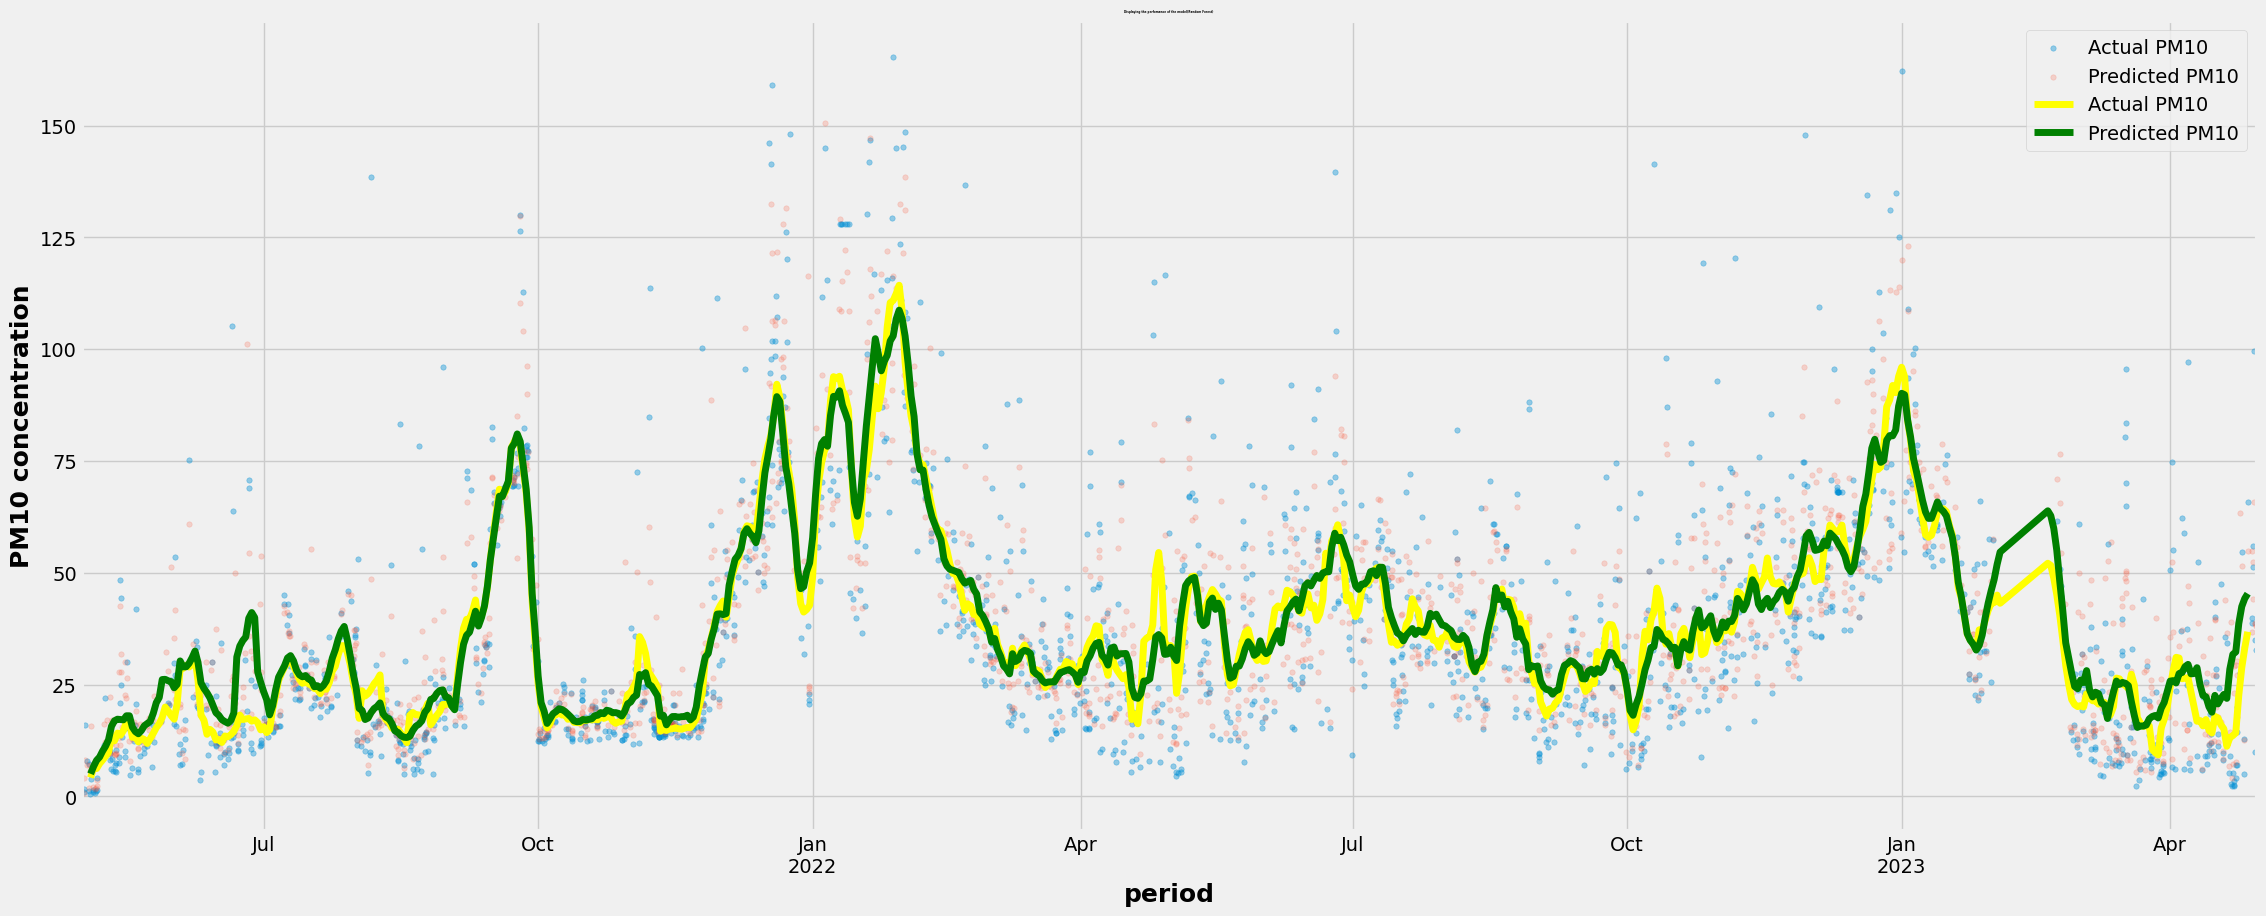

In [55]:
# we now use the best model (Random forest model) to predict the PM10
# concetration and compare it to the actual PM10 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'Actual PM10':y_test,
                            'Predicted PM10':best_model.predict(X_test.values)})
colors = {
    "Actual PM10": "yellow",
    "Predicted PM10": "green",
}

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(25,10))
    plt.scatter(compare_data.index,compare_data['Actual PM10'],s=15,label='Actual PM10',
               alpha=.4)
    plt.scatter(compare_data.index,compare_data['Predicted PM10'],s=15,label='Predicted PM10',
               alpha=.2)

    compare_daily_data = compare_data.resample('D').median()
    compare_daily_data.interpolate(inplace=True)

    for column in compare_daily_data.columns:
      decomposition = seasonal_decompose(compare_daily_data[column], model='addictive')
      # plot the data
      decomposition.trend.plot(linestyle='-', alpha =1, color=colors.get(column, "grey"), linewidth=5,legend=True, label=column)

    plt.legend()
    plt.title('Displaying the perfomance of the model(Random Forest)',
             fontsize=2, fontweight='bold')
    plt.xlabel('period',fontsize=18, fontweight='bold')
    plt.ylabel('PM10 concentration',fontsize=18, fontweight='bold')
    plt.show();

In [56]:
# Linear fitting of predicted and actual values for the best model (Random Forest model)
lr = LinearRegression()
lr.fit(compare_data['Predicted PM10'].values.reshape(-1,1), compare_data['Actual PM10'])

# Make predictions using the linear regression model
predicted_values_lr = lr.predict(compare_data['Predicted PM10'].values.reshape(-1,1))

# Evaluate the model
r_squared = r2_score(compare_data['Actual PM10'], predicted_values_lr)
r_squared

0.7563656296458042

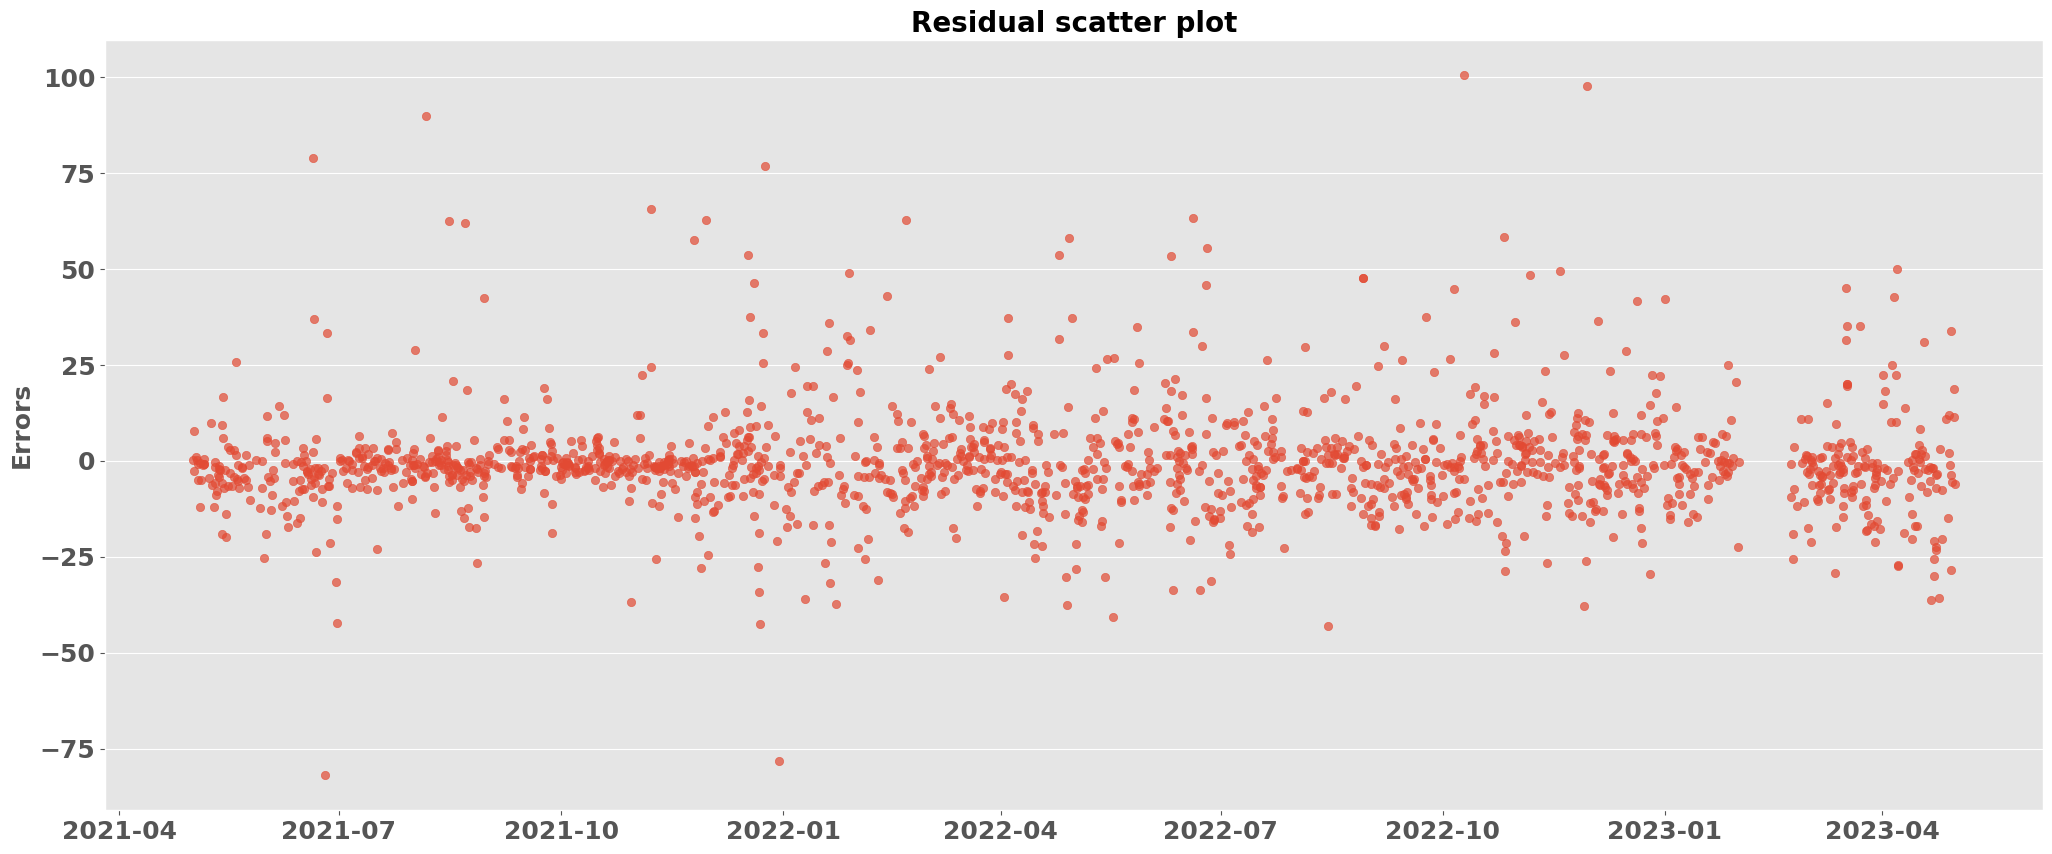

In [57]:
# calculate the errors
compare_data['Residuals'] = compare_data['Actual PM10'] - compare_data['Predicted PM10']

# make a scatter plot of the errors to see if they follow any pattern
with plt.style.context('ggplot'):
    plt.figure(figsize=(25,10))
    plt.scatter(compare_data.index,compare_data.Residuals,alpha=.7)
    plt.title('Residual scatter plot',fontsize=20, fontweight='bold')
    plt.ylabel('Errors',fontsize=18, fontweight='bold')
    plt.grid(axis='x')
    # Get the current Axes object
    ax = plt.gca()
    # Increase the size of the x and y tick labels
    ax.tick_params(axis='both', which='major', labelsize=18)

    # Set the font weight to bold for x and y tick labels
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.show();

<Figure size 2500x1000 with 0 Axes>

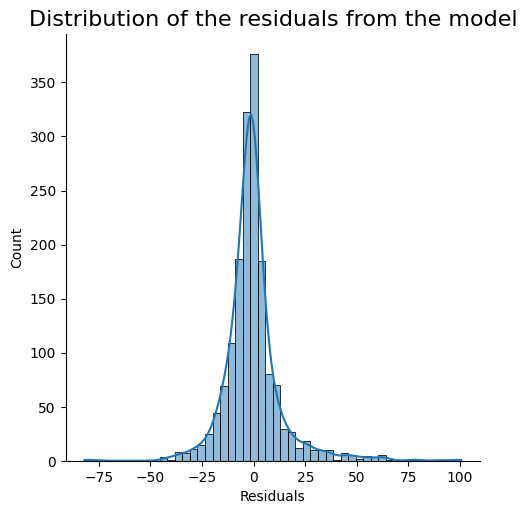

In [58]:
# plot the histogram to see check the normality of the errors
plt.figure(figsize=(25,10))
sns.displot(compare_data.Residuals,bins=50, kde=True , lw=5)
plt.title('Distribution of the residuals from the model',
         fontsize=16)
plt.show();